In [3]:
import pandas as pd
import numpy as np
import time 
import os.path
import datetime
import help as hp
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn import metrics

from sklearn.feature_extraction import DictVectorizer
import matplotlib.pyplot as plt


# 为notebook提供更加漂亮的可视化
%matplotlib inline

## 文件名

In [36]:
np_file_pre="data/np_array/B_"
csv_file_pre=""

## 读取经过处理后的全量数据

all_train_data_20170102_20100326.csv  



In [4]:
all_data=pd.read_csv("B_all_train_data_20170102_20100326.csv")

### 取训练数据

In [5]:
train_data=all_data[(all_data['date']>=20170102) & (all_data['date']<=20170312)]


In [6]:
train_data.head()

,grid_id,date,hour,car_number,temp,humidity,wind_speed,weather,dayofweek
0,51,20170102,8,9.0,11,94,7.2,4,1
1,51,20170102,9,14.0,13,88,10.8,4,1
2,51,20170102,10,7.0,13,88,18.0,2,1
3,51,20170102,11,8.0,15,77,10.8,2,1
4,51,20170102,12,7.0,15,72,10.8,4,1


## 观察数据

In [7]:
def distribution_by_featur(data, x_feature, y_feature, date_flag=True):
    if date_flag:
        #日期传入是int64，转成字符串
        dates=data[x_feature].astype(np.str)
        xs = [datetime.datetime.strptime(d, '%Y%m%d').date() for d in dates.values]
        x_lables=dates[1:len(dates):7]
        ticks=xs[1:len(xs):7]
        
    else:
        dates=data[x_feature]
        xs = dates.values
    
    ys=data[y_feature].values
    
    plt.plot(xs, ys)
    if date_flag:
        plt.xticks(ticks, x_lables)
        plt.xlabel('Date')
    else:
        plt.xlabel('Day of week')
    plt.ylabel("car numbers")
    plt.title("Distribution of car numbers by {}".format(x_feature))
    plt.gcf().autofmt_xdate()  # 自动旋转日期标记
    plt.show()

In [8]:
# 按星期的天数统计车量分布情况
byweekday = train_data.groupby('dayofweek')
#byweekday=byweekday['car_number'].mean().reset_index()
#byweekday=byweekday['car_number'].count().reset_index()
byweekday=byweekday['car_number'].sum().reset_index()
byweekday

,dayofweek,car_number
0,1,99253.0
1,2,104409.0
2,3,103216.0
3,4,104765.0
4,5,102809.0
5,6,92929.0
6,7,81863.0


In [9]:
# 按日期统计车辆的分布情况 
byday = train_data.groupby('date')
byday=byday['car_number'].sum().reset_index()
byday.head()

,date,car_number
0,20170102,9996.0
1,20170103,10537.0
2,20170104,11001.0
3,20170105,9790.0
4,20170106,11004.0


In [10]:
# 按小时统计车辆的分布情况 
byhour = train_data.groupby('hour')
byhour=byhour['car_number'].mean().reset_index()
byhour

,hour,car_number
0,8,10.682000
1,9,12.894000
2,10,13.718571
3,11,13.089429
4,12,12.799714
5,13,12.518857
6,14,12.795143
7,15,13.237429
8,16,13.691143
9,17,13.103143


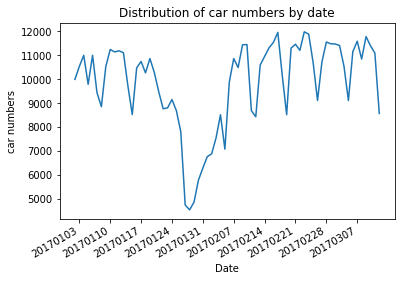

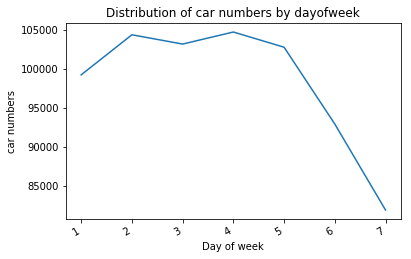

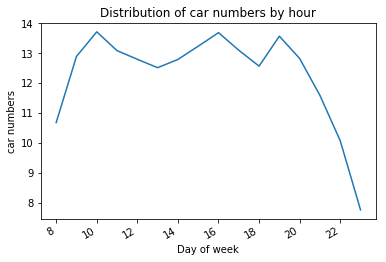

In [11]:
distribution_by_featur(byday, "date", "car_number", True)
distribution_by_featur(byweekday, "dayofweek", "car_number",False)
distribution_by_featur(byhour, "hour", "car_number",False)

从上面的分布图可以看出
- 春节期间：20170127~20170202，车流量是个低俗；可能从训练数据中删除此部分会更好
- 周末的车流量比工作日多
- 上行9到10点，下午16点，19点是流量高峰

In [12]:
# 观察一下日车流量小于6000的日期
byday[byday['car_number']<=6000]

,date,car_number
25,20170127,4749.0
26,20170128,4546.0
27,20170129,4869.0
28,20170130,5786.0


都是春节期间的日期，从训练数据中删除这部分数据

In [13]:
# 观察一下日车流量大于6000的日期
df_tmp=byday[byday['car_number']>10000]

def get_dayofweek(date_str):
    date = datetime.datetime.strptime(str(date_str),'%Y%m%d')
    
    return date.isoweekday()

df_tmp['dayofweek']=df_tmp['date'].apply(get_dayofweek)
df_tmp

E:\Anaconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,date,car_number,dayofweek
1,20170103,10537.0,2
2,20170104,11001.0,3
4,20170106,11004.0,5
7,20170109,10529.0,1
8,20170110,11244.0,2
9,20170111,11145.0,3
10,20170112,11189.0,4
11,20170113,11110.0,5
14,20170116,10478.0,1
15,20170117,10744.0,2


流量大的日期，都是工作日的日期

### 增加节日数据

In [14]:
#20170102-元旦、
#工作日、休息日
#df_festival=pd.read_csv("节日_工作日_数据.csv")
#df_festival.info()

### 删除春节放假的数据

In [15]:
all_data_df=all_data[(all_data['date']<20170127) | (all_data['date']>20170202)]

In [16]:
all_data_df.shape

(61600, 9)

## 归一化、OneHot编码

In [17]:
# 标准化处理连续型和离散型特征
def nomalize_features(data):
    featureConCols = ['grid_id','temp','humidity','wind_speed','hour']  #连续型
    featureCatCols = ['weather','dayofweek']    #离散型
    #date字段，考虑删除，当连续型和离散型都不合适
    
    # 我们把连续值的属性放入一个dict中
    dataFeatureCon = data[featureConCols]
    X_dictCon = dataFeatureCon.T.to_dict().values() 

    # 把离散值的属性放到另外一个dict中
    dataFeatureCat = data[featureCatCols]
    X_dictCat = dataFeatureCat.T.to_dict().values() 

    # 向量化特征
    vec = DictVectorizer(sparse = False)
    X_vec_cat = vec.fit_transform(X_dictCat)
    X_vec_con = vec.fit_transform(X_dictCon)
    
    # 标准化连续值数据,让连续值属性处理过后均值为0，方差为1
    scaler = preprocessing.StandardScaler().fit(X_vec_con)
    X_vec_con = scaler.transform(X_vec_con)
    
    # 离散特征one-hot编码
    enc = preprocessing.OneHotEncoder()
    enc.fit(X_vec_cat)
    X_vec_cat = enc.transform(X_vec_cat).toarray()
    
    #连续型、离散型特征拼接
    X_vec = np.concatenate((X_vec_con,X_vec_cat), axis=1)

    #结果值
    Y_vec = data['car_number'].values.astype(float)
    
    return X_vec, Y_vec


### 按记录数切分验证数据和训练数据【因为数据标准化后，没有日期字段】
- 所有数据一共12周，前10周是训练数据加验证集
- 每一天800条记录：16*50

| 数据集 | 天数  | 记录数 | 起始下标 | 终止下标 |
| :-: | :-:  | :-: | 
| 训练集  | 49 | 39200 | 0 | 39200|
| 验证集  | 14 | 11200 | 39200|50400|
| 测试集  | 14 | 11200 | 50400|61600|

- 训练数据到20170226  8周减去春节放假一周，共49天 39200条
- 验证数据后两周:20170227-20170312  14天  11200条
- 测试数据：20170313-20170326  14天  14*800=11200条

In [18]:
#按日期排序后才能按记录下标切分数据
df_tmp=all_data_df.sort(columns=['date','hour']).reset_index(drop=True)
df_tmp.head()

E:\Anaconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  


,grid_id,date,hour,car_number,temp,humidity,wind_speed,weather,dayofweek
0,51,20170102,8,9.0,11,94,7.2,4,1
1,52,20170102,8,1.0,11,94,7.2,4,1
2,53,20170102,8,3.0,11,94,7.2,4,1
3,54,20170102,8,2.0,11,94,7.2,4,1
4,55,20170102,8,2.0,11,94,7.2,4,1


### 取测试数据

In [38]:
test_data=df_tmp[(df_tmp['date']>=20170313)].reset_index(drop=True)
test_data.head()
#保存数据,方便后面加载
test_data.to_csv("B_test_data.csv", index=False)

In [20]:

X_all, y_all=nomalize_features(df_tmp)

x_train=X_all[0:39200]
y_train=y_all[0:39200]
x_val=X_all[39200:50400]
y_val=y_all[39200:50400]
x_test=X_all[50400:61600]
y_test=y_all[50400:61600]

print("x_train rows=", x_train.shape)
print("y_train rows=", y_train.shape)
print("x_val rows=", x_val.shape)
print("y_val rows=", y_val.shape)
print("x_test rows=", x_test.shape)
print("y_test rows=", y_test.shape)


x_train rows= (39200, 17)
y_train rows= (39200,)
x_val rows= (11200, 17)
y_val rows= (11200,)
x_test rows= (11200, 17)
y_test rows= (11200,)


### 保存数据

In [37]:
np.save(np_file_pre+"x_train.npy",x_train)
np.save(np_file_pre+"y_train.npy",y_train)
np.save(np_file_pre+"x_val.npy",x_val)
np.save(np_file_pre+"y_val.npy",y_val)
np.save(np_file_pre+"x_test.npy",x_test)
np.save(np_file_pre+"y_test.npy",y_test)

In [21]:

print(y_train[30000:30200])

[ 7.  0.  1.  3.  5. 17.  2.  3. 12. 15. 12. 14. 21. 11. 23. 17. 27. 23.
  9. 15. 14. 16. 17.  7. 14.  1. 14. 22. 23. 19. 10. 16. 24. 20. 17. 21.
 44. 17. 20.  7.  2. 52. 31. 12.  8. 16. 15. 37. 35. 12.  7.  0.  4.  8.
 12. 10.  7.  3. 12. 15. 11. 13. 22. 13. 11.  9. 15. 16.  6. 10. 17. 13.
 16.  8. 10.  2. 11. 19. 21. 15.  8.  9. 13. 20. 22. 12. 44. 12. 19. 10.
  4. 56. 27. 17.  8. 12. 25. 37. 33. 10.  4.  0.  1.  6.  8. 12.  2.  6.
 10.  9.  7.  6.  9. 13. 17. 10. 19. 17.  8. 16. 17. 18. 18.  6. 14.  6.
 16. 12. 13. 16. 10. 12. 13. 16. 24.  7. 41. 11. 26. 11.  5. 44. 28. 20.
 11. 19. 24. 33. 26. 25. 14.  0.  5.  6. 13. 12.  2.  1. 16. 21. 19. 23.
 26.  6. 16. 14. 20. 12.  9. 31. 33.  9.  9.  5. 19.  5. 11. 26. 24. 15.
 13. 11. 12. 13. 20. 16. 51. 16. 43. 24. 14. 68. 40. 16.  2. 12. 24. 49.
 40. 18.]


## 模型训练

In [32]:
def fit_and_predict(model, name, x_train, y_train, x_val, y_val):
    start_time=time.time()
    model.fit(x_train, y_train)
    print("modele:",name, "fit time", time.time()-start_time)

    y_train_pred = model.predict(x_train)
    print ("modele:", name, "Train RMSE:",np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)))
    
    #预测验证集
    y_pred = model.predict(x_val)

    print ("modele:", name, "RMSE:",np.sqrt(metrics.mean_squared_error(y_val, y_pred)))
    print ("modele:", name, "RMSE CEIL:",np.sqrt(metrics.mean_squared_error(y_val, np.ceil(y_pred))))
    print ("modele:", name, "RMSE round:",np.sqrt(metrics.mean_squared_error(y_val, np.round(y_pred))))
    print ("modele:", name, "RMSE floor:",np.sqrt(metrics.mean_squared_error(y_val, np.floor(y_pred))))
    
    
    return model

def my_predict(model, name, x_test):
    #预测测试集
    y_pred = model.predict(x_test)
    
    df_y_test=pd.DataFrame(y_pred) #0313--0326的预测值
    df_y_test.rename(columns={0:'car_number'}, inplace=True) #先转成df，再合并
    
    df_test_pred=test_data[['grid_id','date','hour']].reset_index(drop=True)   #0313--0326的基础数据
    df_rel= pd.concat([df_test_pred, df_y_test], axis=1)
    
    df_rel=df_rel[(df_rel['hour']>=9) & (df_rel['hour']<=22)] #去掉8点和23点的数据
    
    df_rel.rename(columns={'date':'day'}, inplace=True)
    now_time = datetime.datetime.now()
    df_rel.to_csv("data/pred/B_{}_{}.csv".format(name, now_time.strftime('%Y%m%d%H%M%S')), index=False)
    #向上取值RMSE更小
    df_rel['car_number'].apply(np.ceil)
    

In [23]:
#线性回归
lr=LinearRegression()
# 随机森林回归
forest = RandomForestRegressor(n_estimators=1000, criterion='mse', random_state=1, n_jobs=-1, verbose=1)
#梯度提升回归
gbr=GradientBoostingRegressor(n_estimators=3000, learning_rate=0.1, random_state=1, verbose=1)


In [24]:
model_lr=fit_and_predict(lr, "LinerRegression", x_train, y_train, x_val, y_val)
model_rfr=fit_and_predict(forest,"RandomForestRegressor", x_train, y_train, x_val, y_val)
model_gbr=fit_and_predict(gbr, "GradientBoostingRegressor", x_train, y_train, x_val, y_val)

modele: LinerRegression fit time 0.5240299701690674
modele: LinerRegression Train RMSE: 8.141122490482447
modele: LinerRegression RMSE: 8.612525393187381
modele: LinerRegression RMSE CEIL: 8.617118552210892
modele: LinerRegression RMSE round: 8.617232527242805
modele: LinerRegression RMSE floor: 8.651733930259299


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   48.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.2min finished


modele: RandomForestRegressor fit time 97.27456378936768


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:  1.8min finished


modele: RandomForestRegressor Train RMSE: 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    2.8s finished


1.3686911048183141
modele: RandomForestRegressor RMSE: 4.042097218277769
modele: RandomForestRegressor RMSE CEIL: 4.008083350288158
modele: RandomForestRegressor RMSE round: 4.049040891724501
modele: RandomForestRegressor RMSE floor: 4.154569343334087
      Iter       Train Loss   Remaining Time 
         1          82.2489          317.06m
         2          76.3585          170.37m
         3          71.5848          114.56m
         4          67.1431           86.70m
         5          63.7197           69.95m
         6          60.9261           58.76m
         7          58.0327           50.83m
         8          54.4742           44.86m
         9          52.6902           40.20m
        10          51.2965           36.47m
        20          38.2594           19.97m
        30          32.6885           14.19m
        40          29.2741           11.20m
        50          27.1495            9.40m
        60          25.8766            8.18m
        70          24.8631

In [31]:
#my_predict(model_lr, "LinerRegression", x_test)
#my_predict(model_rfr, "RandomForestRegressor", x_test)
my_predict(model_gbr, "GradientBoostingRegressor", x_test)

## 预测验证集跟结果评估
评估标准：上传结果后组委会会通过评价指标RMSE(均方根误差)进行排名，RMSE用car_number计算。
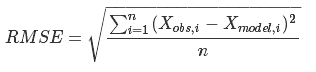


In [26]:
y_pred=model_gbr.predict(x_val)
# 用scikit-learn计算RMSE
print ("RMSE:",np.sqrt(metrics.mean_squared_error(y_val, y_pred)))


RMSE: 4.13779275482995


In [27]:
print(y_val[:100])

[ 9.  0.  4.  7.  3.  6.  5.  5. 13. 13. 13. 16. 24.  9. 10.  5. 11.  8.
  5. 14. 17.  8. 25.  1. 14.  4.  7. 16. 13. 22.  8. 18.  9. 11. 10.  8.
 26.  5. 20.  5. 12. 42. 25. 12.  4.  9. 19. 29. 25. 10.  5.  0.  2.  9.
  5.  9.  4.  2. 15.  8. 10.  9. 14. 14. 16. 10. 21. 18.  8. 20. 15. 17.
 25.  2. 11.  2. 14. 12. 17. 16. 11. 13. 16. 15. 13. 15. 44. 13. 23. 13.
  5. 55. 29. 13. 11. 15. 22. 39. 36. 12.]


In [28]:
for i in range(len(y_pred)):
    print(y_pred[i])
      

6.663251349647711
-0.3793790269003195
2.34155920357806
3.852766346623357
3.6924193073733176
7.166211816108941
1.3367332358161093
2.958923786337831
8.299626261714144
13.239006180993607
11.15103792537208
12.747543124578746
18.662080105715027
9.187442373454962
10.476039421538713
7.168655574767574
12.692661887262455
12.269428306981428
3.3285665923621353
12.194642583913637
12.559880112258528
10.44917931051458
16.68323743868302
3.719403086316126
7.183917562110802
1.0984892477828385
7.918013072940793
13.664411730988721
14.131175479200012
11.780895403836738
6.192099393054963
7.3705462181177674
9.921622450958134
9.547188867212817
10.861813755923416
7.838596799951265
24.028326904447262
7.39330290006185
15.75144716560723
10.057090480400108
4.35863495940701
35.37768644178238
20.82675802047444
10.673717554720149
3.215393736903381
9.563148030217778
12.908972248985036
24.818686625859087
24.118026943430152
11.52081633325241
7.979154435441581
0.856007104147131
3.576945334625512
5.643747067429493
5.5842

8.732861649298801
14.599086772798831
15.419020204035808
12.963027568331249
7.264805204577138
8.371126114500864
10.954442603124127
10.71366716088103
12.703710803579556
9.77198746315249
27.528124980944646
9.215239343799956
18.691689599259377
12.062087586279109
6.353864267159181
38.932964212118335
24.351798421277888
13.935758323245125
6.383209411548068
13.304022160224516
16.67167048894837
28.844960748911955
27.96037561988935
13.87285180507987
6.269076192855628
-0.18915823415850486
2.531779996319874
4.659025729166288
4.722599644255786
7.99151560324138
1.97952249544544
3.2526300721906045
8.772425959735099
13.926428323736431
12.030917254552538
13.57895068148993
19.383019968000305
9.133496997604576
10.485481323764418
8.305139043621745
15.372704108117174
15.04634136887305
5.6227793804774535
14.081131238253617
15.28936745260644
13.433761342690048
19.0501817402026
5.803479236603729
8.850297579213972
2.2355683638720043
9.792757917295022
15.124875018538084
16.763302406367302
13.48308270575635
8.68

9.655550681816578
11.119351394184616
7.911803775961131
25.89641128999759
7.899432068829414
16.988746641987177
10.196411816647897
4.387425899419907
36.385479894477285
21.81351581420862
11.01926114537204
3.46341162430288
9.819358663864055
12.89031933376269
26.266787774019473
25.36041128674695
11.526691560318119
6.408648508857856
-0.04357894483866851
2.760597996366989
4.914690061787586
5.022786261921488
8.2917022209071
1.9695848795457622
3.2470106823206395
8.809928930647837
14.55935283060695
12.612765052450493
14.1689613425774
20.03972972732267
10.166598424115858
11.614834558965105
9.79574558015581
16.727608216399698
16.401245477155598
6.959667429488516
15.481346621204896
16.494345515612196
14.18058098273836
20.19349289646528
6.838877070613435
10.078882174707491
3.508413443625195
11.084683847058367
17.00393436654836
18.320427382618618
14.54467672511066
9.660103473452272
10.766424383376034
14.242172500260715
14.118762938041558
16.426500265439
13.79845374470668
38.61613690038764
16.10122200

15.626376180893363
18.953382906340806
15.734695810074518
37.133113807887
13.239339016818134
25.373435487126773
14.056440408414675
7.421484531941967
46.64153493914102
28.5924880768843
16.29107350821945
6.711613557359429
12.695782824483706
19.139715668556555
30.739285232880917
29.806203784534397
16.235708112350956
7.224119647596295
2.069323643872093
4.718446927176069
6.8927225640888015
8.700857842486032
12.789178021617378
4.50300427343433
5.150241513151348
11.09616989218204
15.10514787195046
13.738964454278529
14.967792798539751
19.335968520601718
12.235698452480834
14.947940254984813
13.404064788817612
18.53131098791923
19.365715186242568
9.66073816105854
19.461866102563388
20.83504032134117
14.99875295560953
15.025522561311973
9.72723570142553
13.775884693729884
6.73962126277829
15.071081920076994
18.038813726514462
18.851811349553156
15.376816158311804
10.687945603389716
10.272099437857143
17.134151059935018
18.036236410046595
22.20677553743156
17.999842069660552
39.40762246817072
15.

12.570784499424109
12.47921127341718
15.38929490559498
11.105139267590538
36.51593563823586
11.512395637105577
17.745864024484646
11.591677546640916
3.197405573418531
47.11740720378352
27.33319814051213
12.844502156329053
4.875052696021428
12.011686043376798
16.76378651115353
35.10735725044226
34.56769058430605
10.915913184985508
5.276280640950423
-1.608107486807987
1.1897786635385166
3.4373927264886257
3.746905226106923
8.093647787683457
-0.1522595755625121
0.7821796259620136
6.745998335868672
12.176250163356292
10.304260344387139
11.848530006295334
17.367633509244524
7.542157848706751
9.541622343746281
8.501882061497199
15.426440252420507
15.127196236410784
4.724513381168343
11.705845911272462
12.547853863473744
10.636002404994397
12.770399936248948
3.595071671175927
7.647938013797584
0.8743790744656623
8.602997140615418
14.56770537993213
15.342752925963774
10.681348233518037
6.585130618784051
6.605737369835731
12.43180640529122
12.507998244473638
15.418081876651424
11.58067009704736

7.709903994326247
8.816919245780467
13.196527623042497
7.9569210422725245
19.985744130733636
4.8368604973745715
18.148627755392496
5.044879191256083
1.1271021289092293
31.539001582648
19.314625528213615
11.840541253922595
-0.33168167401989684
5.693010034103079
13.444321013703775
20.19146365922589
19.63605324858481
10.348266333588551
2.627578721431684
-1.5761797355862015
-0.15568720485192886
1.170743791030217
2.7833913115102487
5.877850855094259
-0.9829832791210561
-0.8773074984623728
4.437550650280178
7.073438060461346
5.643873423904916
6.874857614029718
11.039519127682889
4.214023772913645
6.955924424862888
5.502621476758264
9.40067251370346
10.843921240958455
1.0237541852649863
11.649726599496326
11.199370355533897
5.671044305238798
5.00441928406073
1.7622351118236506
5.924913882113366
0.3631694694063103
7.123942250890289
8.467099206934675
8.950761904532119
5.744148395769087
1.7952580094432211
1.3794118439106435
8.851896906572977
11.541024601137995
14.401955690428656
7.15464322433084

10.447775121511187
16.60328712271852
16.82702831365462
20.15403503910209
16.93644222747669
39.19052803674448
14.843233101796068
25.79446464474775
16.04381423202536
8.22602396594972
50.44100597779153
31.098620823636416
18.041146536597253
9.614280966352968
17.092019981477293
22.52651658926918
36.34771509483964
36.01949700597817
19.325054989422476
5.756978101124566
-0.3330493480704697
2.4005922734073564
4.528061925067446
6.3616843550410636
10.617759731245128
1.9790355829071113
2.7761804145624702
8.74892645815813
13.42468885286294
11.557584023101084
13.334195445843111
19.45003950663432
9.689403212533735
12.552481897684018
11.156823396408363
16.671363428065362
16.410926040392226
7.174484248376968
16.03434645160032
17.953945367317214
13.110790258833088
13.445618949886738
7.502335788541652
11.008780505969609
4.421909792799692
13.247160204024143
17.46731496470197
18.12531239112741
13.602299880699404
8.99395575435591
8.953932899333678
14.94648901808263
15.058077337713732
18.385084063161234
15.1

11.406594940435467
11.49673315766463
17.53093836490526
17.609574987759654
20.401296945210547
17.70271348180635
41.22957939362298
16.568972772807047
23.408065375334676
17.148723822026042
9.218261862464088
52.808600123265734
33.85889025544923
18.805767728565694
11.230527924140501
18.99845705129574
23.75354164572116
40.22594855227602
39.898315788294454
22.276334183890267
7.568753889608817
1.666715818605566
4.721372383577906
6.495077676984866
6.764183953351341
12.51178972284183
3.4503178282705775
4.379973090257103
10.145013499137523
18.049727154951626
16.087887724400307
17.486225479100337
23.606732277360592
12.768608525725844
14.363412265690274
14.54542912185811
20.45504600681569
19.702208875844303
9.172684601447504
16.222915910341683
17.073003671221766
15.347864539959367
16.1281640322605
8.808095029570753
13.384468517700709
7.213247298192996
15.262870605391193
20.05210553961174
20.611740123651224
15.996719467423105
11.931272458658505
11.923411499955211
17.7052837207528
17.810305586156698


9.645732575886136
9.229886410353561
16.17006563415755
17.599613700252
21.656924477155204
16.666960617335302
36.21040140462843
13.260231057629706
26.12234040605687
14.895005947260206
8.525553689692687
47.85716734547243
29.981592862118905
19.09271800333505
9.732592850305734
15.222171596037644
22.52989777241651
33.91192541128402
33.290182636759155
23.99847074716398
6.3306585060430764
2.209459636768631
4.507467870949637
6.502889055007032
8.205825560633258
12.303467812760909
4.090053061367906
4.419702301596515
10.346747019912762
14.29690508196558
13.077193472184897
14.272748163759932
18.722444689396067
11.578380250128836
14.478872021925541
13.408886557732297
16.947621501919226
18.39087022917423
8.839642024591859
20.04257651375904
20.36706662356038
13.217515952311494
11.540760367113911
9.939229829364908
13.852102166626931
6.929631106999109
15.260126898198687
17.793674824390337
18.216071282379485
14.441457476098984
9.935604331306482
9.519758165773908
16.47358235150452
17.870964892644622
21.92

12.692132610961204
8.597912462019131
8.519757688379405
13.407219252339345
13.824216171137724
17.058980200504987
13.382967568362043
32.776877308002646
11.082204925163635
19.512677878525484
11.676714415823088
5.071369767281866
40.18086678248657
23.699564699725897
14.691456474969598
6.988139502819432
13.886961455745203
18.33580422940916
28.983555463639956
28.62082290677354
17.096534967215682
6.1739707439388605
0.15173289197699405
2.6089795224355297
4.54660380721757
4.754268384214817
9.48965086457351
1.2191739451469394
2.0365510642062823
7.941687589938441
13.84553195845331
11.842295856740696
12.943715824298552
18.09470602128508
8.833947436854444
11.22541046873029
10.327724555170962
16.196276912387063
15.971555607609988
5.552550764310637
13.098661354900774
14.690857814273313
11.089549658909261
11.302582491798562
4.623183031818887
8.742984786802888
2.827401698876875
10.682256793985054
16.23414527687152
16.570227353715925
12.157230565797423
7.462682470843073
7.384527697203346
12.7810371032730

14.606802053518411
9.027924166888985
10.206370991951788
13.018062656395516
12.568970369756672
13.880516429482913
10.35813702097361
29.184006704907965
10.601936784563662
18.939166453568305
12.53736484029861
6.607769036172753
39.2332151666175
23.337012954734984
12.094067399449415
4.296457629770565
10.680223326680732
14.348335020854343
27.633254303514914
26.886890634515684
14.05581093085017
7.597068229163841
0.40495820147264605
3.202844351819152
5.412829908334245
5.296282776631881
8.62406148817944
2.4959665246908957
3.7196737938648594
9.401384010223303
14.947329087898188
13.026247620509029
14.570517282417224
20.298729547422965
10.2133313693111
11.561578344756986
9.195537473978542
16.285421270828575
15.937276183058822
6.418495734074854
14.335166981302446
15.241688881851944
13.319304564452016
18.920343296794513
5.813139040169766
9.183553980468146
2.6334421217705692
10.199087696956354
15.995128297300223
17.085396698403958
13.5949416014083
8.78720869455148
9.89352960447524
13.61448075518858
1

15.132120223447535
11.83326386487882
7.149748476152751
7.109725621130517
12.934680696210979
12.8969327518697
16.07476365365966
13.212971536532713
33.123347379885836
11.412359909832873
22.24550559585387
12.168689923188971
5.262701189914349
43.06669569088362
25.05106861417637
13.470480998776692
5.158851374531254
11.735153072142037
18.238774405645604
29.169958196287137
28.76886757287513
16.316358435475813
4.492442283399818
-0.8624552711072444
1.7371464693784238
3.8188802243253743
5.395922725407865
9.46579641614667
1.1813895776164374
1.7928664484113788
7.7607964235408735
11.411946006701964
10.056638079816366
11.284114137089738
15.677111895316814
8.61824060725438
11.213497699361767
9.535876074662632
14.479034261690913
15.222990954668008
5.9245670412378395
15.263770199694417
16.641081998393286
11.140033748249063
10.803207037383629
6.183228823968341
10.421565135332527
3.2121441765955234
11.5216442508822
13.863857386112839
14.50484093899295
11.225121724691038
6.541606335964982
6.12576017043240

16.39006345878168
17.079320979286905
12.70344511241279
8.525155333561024
8.157801539736571
13.91200419437359
13.812453564473442
16.711265722209347
13.424094487039135
37.63840402780914
13.178051702923307
19.258084993090954
13.42011305920794
5.457460942351447
47.86218720888202
28.419320153819932
14.286769293151886
7.014193633888284
15.11066053209995
19.682817951238732
37.09297830913576
36.6212907570379
15.594263482998638
5.884962214917705
-0.16842749817945213
2.5862279002079145
4.702769180739302
5.132177061729882
9.87894587162853
1.1569337307701035
2.0873344717874605
7.9257583055172125
14.152862109383413
12.122837933054925
13.702963110686476
19.375160633679698
9.239810870293095
10.89533875230719
10.283449937827605
16.33351566181419
16.029035914444297
6.118126118714175
12.937875038208965
14.011820020389765
12.365991993286297
14.363401993361014
5.107689590008758
9.011916163134899
2.31816323342485
10.297909989166259
16.396029677132688
17.201733879305962
12.590795952863477
8.412506174011707


13.776433986703312
14.11584435846577
10.741774176740064
6.304640689743924
5.888794524211347
12.846175296819428
14.01303765615218
18.44368401036085
12.979658025084959
28.03743446997953
10.620408782095625
24.64769545840098
10.409346118493502
6.835977947005384
38.765973734224126
25.94521478053741
17.49304983098917
4.841799972838586
10.488330120937672
18.611803574467057
26.872522595440167
25.974905875198782
19.48562488972932
3.7301425573809555
-0.07706619627664311
1.3434263344576283
2.6698573303397675
4.261821251210364
7.647272463010037
1.1010687316454812
1.2202018131758863
6.341808451162718
8.888463940241213
7.494737117102692
8.75082799753534
12.941907124561908
6.217920331222833
9.004773963915165
7.54257597219543
11.29900166115457
12.742250388409564
3.0115946020489357
13.996298260604261
13.83432720761105
8.427800967915028
7.828885388881637
3.9375525410619177
7.747404679915567
2.065315774329317
8.792025118774355
10.490117048247262
11.022549392300743
7.675606764447078
3.595194577521687
3.17

12.794177638317404
18.330860281945252
19.091922839238137
14.248812685708877
9.502698023861125
9.424543250221399
15.793836374523407
16.01757756545949
19.344584290906997
15.808890489284906
40.17157436433105
14.148405918290031
24.54275311522386
14.323481960898258
6.039645026976798
49.10827356333452
29.234423106603444
17.10050004535812
8.67712106839334
15.537972680985085
21.056400798361597
35.11197981033621
34.551395346010935
17.14125443406583
6.017106780189965
0.0751750409146525
2.858338205210765
5.126140462408569
6.913780522429696
11.212044879388943
2.5026394506460625
3.3355446512234965
9.418015863767657
14.140129230987657
12.362136163368191
13.99220312124357
19.95831411764515
10.807253048710386
13.49986479296288
12.116830747117138
18.221281821634527
17.922037805624818
7.713750065152006
16.49827526205844
18.25789135830574
13.452861791968202
14.1846638157226
7.677284050410173
11.073197811563578
4.719793143157255
13.384298430267629
17.692508385258247
18.439361072532105
13.525839531740074
8

14.134033658621117
21.12840705866434
21.616547260874714
16.94348984965123
12.847272234917286
12.93741045214645
18.784227261588786
18.7411685391122
21.532890496563148
18.029509990680086
44.652481050679555
20.430133084901513
26.60896389433182
20.728867714570377
12.695675364084181
56.97401506754081
37.402840529937855
21.578800190211116
13.674492612717401
20.748318608402826
25.306087121432277
43.549119140753106
43.03260278117449
20.273222716960632
9.679521550544347
1.6768147638032842
4.431470162190669
6.495079308021759
6.904886188487995
12.466572178596023
3.4142844395227465
4.377825066780706
10.202439830874228
16.779918163323746
14.70986956318409
16.26471356632313
22.21379902348176
11.107507918845675
12.66548207733186
12.67821692686696
19.226233082232884
18.79769305563653
8.58269117636416
15.576529238008847
16.456306724729806
14.434906936677198
16.469363973444835
7.466146961202641
11.258243768841899
4.902780192096279
12.8038485735965
18.936103695005897
19.539014231717132
14.86595682049369


1.940214018773886
10.289016756469934
13.426752676338467
13.790442475319477
9.74346672020896
5.022010157116058
4.606163991583481
11.48195703903223
12.911505105126695
16.968815882029887
11.395517210556076
30.54389494974289
7.619897358038734
20.38003465066621
8.967551015776696
2.726663027753114
41.56261721793325
23.767982500776338
12.071916554520362
2.0291876732392664
7.116592750810863
14.187174833012316
25.346967935077977
24.48205159291304
14.987875133739081
5.015483388722228
-0.21689530238466587
2.081112931796305
4.146168999024878
5.916038986462249
10.013681238589912
1.8421931518220898
2.175880852557843
8.161019428488734
12.084294762272124
10.732637182886467
11.972039868378554
16.42173639401469
8.990352150539184
11.844808486784478
10.580485847742281
14.159823140815227
15.603071868070232
6.032769891030943
17.235704380198207
17.533450076171015
10.516832376219876
9.850207355041798
6.548342435293651
10.47777509782152
3.421851650132059
11.76562755439047
14.67733179970126
15.148196571030507
1

3.3032658314853465
11.541583034164557
17.43434863174123
18.057623569199684
13.396836336601348
9.174108700954262
9.095953927314536
14.904759647457784
15.041241665626396
18.144905045738984
15.81835406709561
38.51617248194907
14.01956713876511
21.30424573028269
14.531452252330613
6.656627584243484
50.71395963472217
31.46873543445671
17.391869610882498
8.828644949333286
16.33638567951826
21.31401481136813
35.438548262551784
34.93624468994175
18.33087341408625
7.287173007688075
0.7766195780358468
3.4872275273811466
5.568199263853771
6.001569599886455
11.43409849877042
2.477446527387472
3.4234556624426573
9.51132534205333
15.58841595028125
13.558216288130218
15.160523901007494
21.01397117046461
11.216289184938997
13.819712760923183
12.950541738347836
18.95499594530254
18.626549721315207
8.300059725193952
15.877542978396418
17.785616485642972
14.558353737629195
15.984123832443153
7.566346823886562
11.704045277415059
4.800621857457529
13.042584129232832
19.04700110839933
19.73914095710752
15.3

7.172717787585985
1.14967887585263
7.946370292569313
13.544607556226165
13.997812724658377
11.103720891848617
4.750677924520234
5.856998834443996
8.136119756594413
7.705947607251222
9.172827148603591
4.408071005779607
19.78193050840858
1.6286880263662062
11.092678660124351
4.488633461666178
-1.3983351537152682
30.22640429970665
15.471943694781409
5.702972653709116
-1.8737413677596306
4.379610267949086
7.35530168201233
19.409587516558627
18.95473694298827
8.4363796482318
5.552379387520215
-0.7281457166332945
2.103457601622199
4.29214123371619
4.309306704568141
7.637085416115736
1.3813299591921855
2.4804741202957183
7.859528471548924
13.121228818909442
11.32651592301276
12.741059005869309
18.678971638464756
8.263327448555566
9.62540638525339
7.565947670311302
14.628426964413876
14.302064225169751
4.725880112848229
13.270659107747285
14.141299894171663
11.729825777929351
16.431501533062047
5.0746387479719575
8.183542319351766
1.659108241112994
9.1643200153042
14.795981263589834
16.0031036

11.650518589214945
4.8035096496019944
13.535137724104345
16.825735699075437
17.45837112732706
13.30997883109823
8.719767909819808
8.61718817719168
15.048897242692824
15.138214768157535
18.46522149360495
14.88401076596222
38.053715296407766
12.36627447240791
24.71840855451237
13.510793938812919
6.654754968346962
47.12527796521203
27.985813916991763
17.58887535011877
8.359715393224896
14.028772475480785
20.523798729364326
32.334902463225504
31.689594883198637
19.875975837375204
4.612575620190621
-0.12678648820645735
2.5834803400563313
4.799005681968967
6.579440220820925
10.72662315251431
2.2047179604747633
2.8161948312697147
8.751131245175676
12.840384307789003
11.615781349782157
12.799409413138484
17.276300097321524
10.098138284399454
12.84814646635471
11.460309638093607
16.57217936596122
17.406583564284563
7.909626426280455
17.531789529103033
18.904963747880817
13.051551068057831
11.624485014292548
8.52951356820745
12.573203081644404
5.649105132400271
13.984627757037488
17.170150087156

4.627253699528202
8.723672380508665
2.66570800925395
10.089207026514824
15.727521456695662
16.869439869416944
12.707941930936423
8.622329613948578
8.642936365000262
13.176145239959126
12.998098755611737
15.981371912826937
12.218532969943302
31.96799566847194
11.41008972416537
18.97912393208484
11.665447218816869
5.474970681022593
39.31468681993234
24.01994267713935
13.568769545174492
6.633832607547374
13.224236927623528
16.38807639610829
27.020816562338904
26.775162580193204
16.1777680497779
7.093260703892489
0.5702954504196586
3.140590786162637
5.002499725956707
4.72078366407079
9.078579977299993
1.1428543057996992
1.9625811955000834
6.98408091709027
12.084595266621484
10.222207742979167
11.366453921121458
16.873748592307145
7.733356341743716
9.731193213400868
8.843948062054205
14.787558717999625
14.598454236138084
4.552795278085873
12.538830301976724
13.270928991143451
10.517689192524223
11.522698034004241
4.208878756069787
8.3052974370503
2.2233441525871127
9.646843169848005
15.1809

5.348132919974575
9.445419066500817
3.5281998405502217
11.277685762457011
12.051124901732667
12.236313415485448
8.741658315874137
4.407440425322357
3.991594259789782
9.349736707536179
10.387542391767699
14.848041005514627
9.007305933084128
19.816241473917053
5.839969069171853
20.1757647331498
4.048216506812518
1.293283563994097
25.907789558251995
15.69914496527021
11.931930045480028
-0.9110861917748981
3.4457860969232312
10.674087676905183
15.526825155262669
15.428235421079963
14.12363961987785
3.0135754781982236
-0.709566998559007
0.45756421328849883
1.4719273077022976
2.686419211920269
6.160574559486787
-0.2570486447940681
-0.28242464646088433
4.608748967612841
7.5217111072608205
6.143138925707402
6.805535457423799
10.175233214925948
3.811931882798024
6.536646187233991
5.12783265815367
8.918902955863084
10.381439488901067
0.5949304126462228
11.91247363156178
11.346995898353656
5.033370158196631
3.367360003134527
1.5889498237858561
5.760180830418632
0.952766411390454
7.597152781413828

In [29]:
print(len(y_pred))

11200


In [30]:
print ("RMSE:",np.sqrt(metrics.mean_squared_error(y_val, np.ceil(y_pred))))

RMSE: 4.107864843374058
